In [1]:
pip install nibabel matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import os
import zipfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# **Step 1: Load Data**

In [3]:
# Define paths
data_path = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
zip_file = os.path.join(data_path, 'HNTSMRG24_train.zip')

# Path to save extracted files
extracted_path = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'

# Create extraction directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Unzip the dataset into the specified directory
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract only the 'preRT/' files
    preRT_files = [f for f in zip_ref.namelist() if '/preRT/' in f]
    zip_ref.extractall(path=extracted_path, members=preRT_files)

In [4]:
# Path to the training data
train_dir = os.path.join(extracted_path, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(train_dir)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


# **Step 2: Exploratory Data Analysis**

In [5]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders[:5]: # TODO

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))


In [6]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

print("Image Dimensions:")
print(f"Minimum dimensions: {min_dims}")
print(f"Maximum dimensions: {max_dims}")
print(f"Mean dimensions: {mean_dims.round(2)}")

Image Dimensions:
Minimum dimensions: [512 512  70]
Maximum dimensions: [512 512  77]
Mean dimensions: [512.  512.   72.4]


In [7]:
# Convert voxel sizes to a NumPy array
voxel_sizes_array = np.array(voxel_sizes)

# Calculate min, max, and mean voxel sizes
min_voxels = voxel_sizes_array.min(axis=0)
max_voxels = voxel_sizes_array.max(axis=0)
mean_voxels = voxel_sizes_array.mean(axis=0)

print("\nVoxel Sizes:")
print(f"Minimum voxel sizes: {min_voxels.round(3)}")
print(f"Maximum voxel sizes: {max_voxels.round(3)}")
print(f"Mean voxel sizes: {mean_voxels.round(3)}")



Voxel Sizes:
Minimum voxel sizes: [0.5 0.5 2. ]
Maximum voxel sizes: [0.5 0.5 2. ]
Mean voxel sizes: [0.5 0.5 2. ]


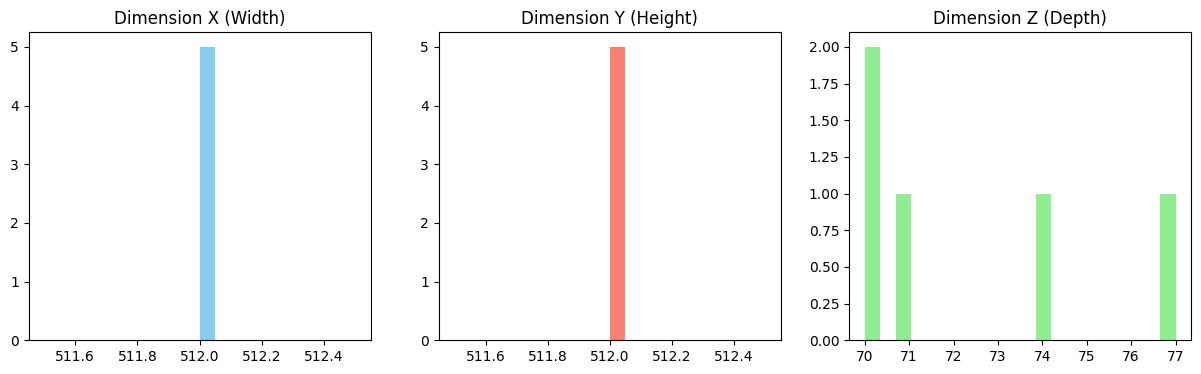

In [8]:
# Plot histograms of dimensions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(dimensions_array[:, 0], bins=20, color='skyblue')
axes[0].set_title('Dimension X (Width)')
axes[1].hist(dimensions_array[:, 1], bins=20, color='salmon')
axes[1].set_title('Dimension Y (Height)')
axes[2].hist(dimensions_array[:, 2], bins=20, color='lightgreen')
axes[2].set_title('Dimension Z (Depth)')
plt.show()

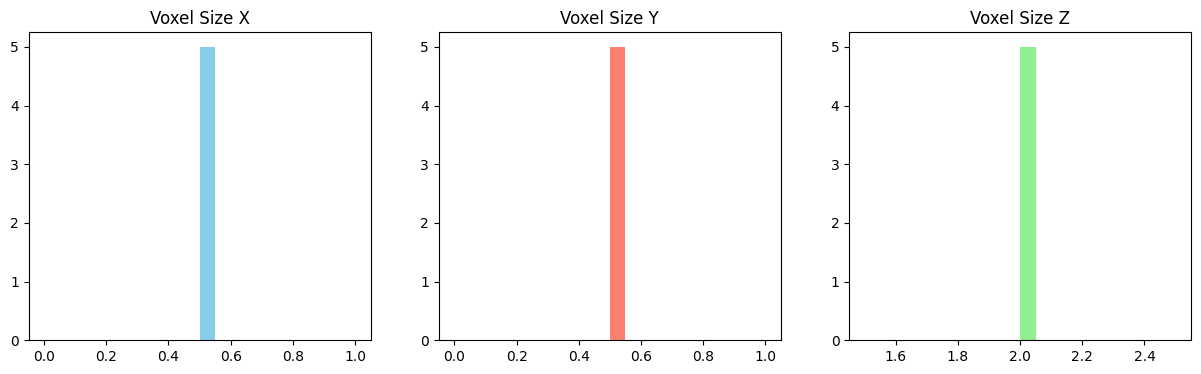

In [9]:
# Plot histograms of voxel sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(voxel_sizes_array[:, 0], bins=20, color='skyblue')
axes[0].set_title('Voxel Size X')
axes[1].hist(voxel_sizes_array[:, 1], bins=20, color='salmon')
axes[1].set_title('Voxel Size Y')
axes[2].hist(voxel_sizes_array[:, 2], bins=20, color='lightgreen')
axes[2].set_title('Voxel Size Z')
plt.show()

In [10]:
# Create a DataFrame from intensity statistics
intensities_df = pd.DataFrame(intensities)

# Display summary statistics
print(intensities_df.describe())

            mean        std  min         max
count   5.000000   5.000000  5.0    5.000000
mean   35.715190  54.064876  0.0  426.200000
std     8.599927  12.888931  0.0   33.566352
min    22.462490  32.638056  0.0  379.000000
25%    32.770304  51.593564  0.0  417.000000
50%    37.457270  60.540675  0.0  427.000000
75%    41.526442  61.106106  0.0  436.000000
max    44.359442  64.445978  0.0  472.000000


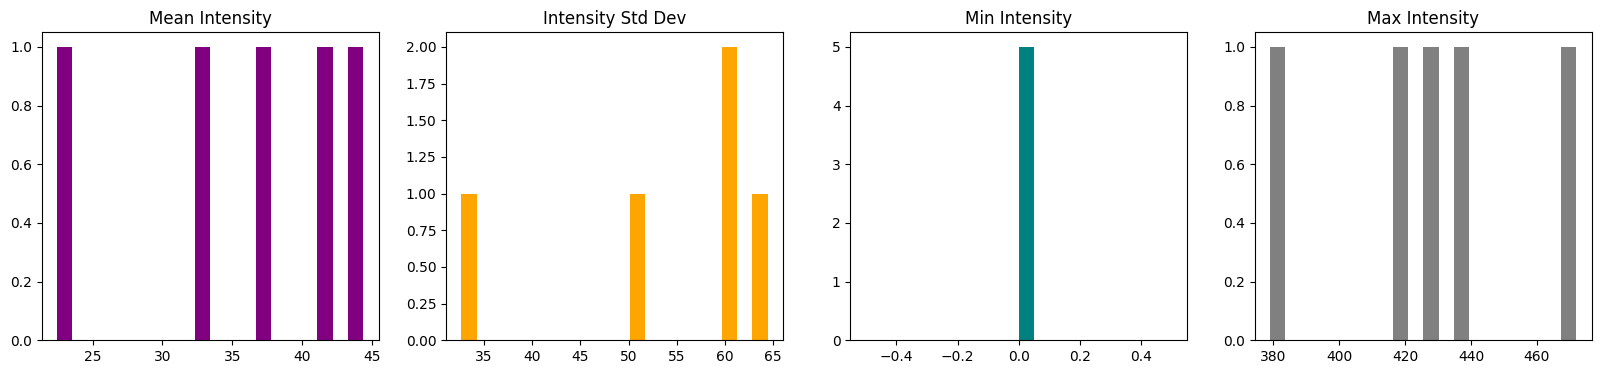

In [11]:
# Plot histograms of intensity statistics
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].hist(intensities_df['mean'], bins=20, color='purple')
axes[0].set_title('Mean Intensity')
axes[1].hist(intensities_df['std'], bins=20, color='orange')
axes[1].set_title('Intensity Std Dev')
axes[2].hist(intensities_df['min'], bins=20, color='teal')
axes[2].set_title('Min Intensity')
axes[3].hist(intensities_df['max'], bins=20, color='gray')
axes[3].set_title('Max Intensity')
plt.show()

**Understand class distribution (Background, GTVp, GTVn)**

In [12]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

print("Class Distribution in Masks (% of total voxels):")
for cls, pct in class_percentages.items():
    print(f"Class {cls}: {pct:.4f}%")

Class Distribution in Masks (% of total voxels):
Class 0: 99.7576%
Class 1: 0.1009%
Class 2: 0.1415%


**Plot samples**

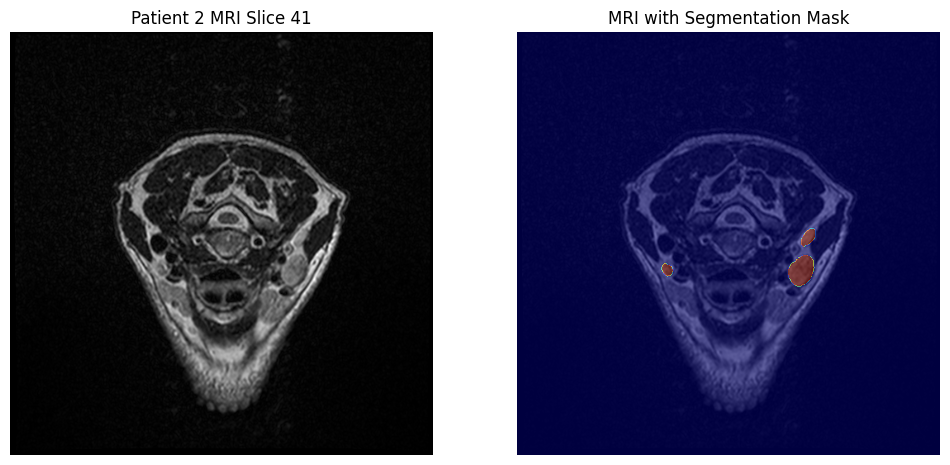

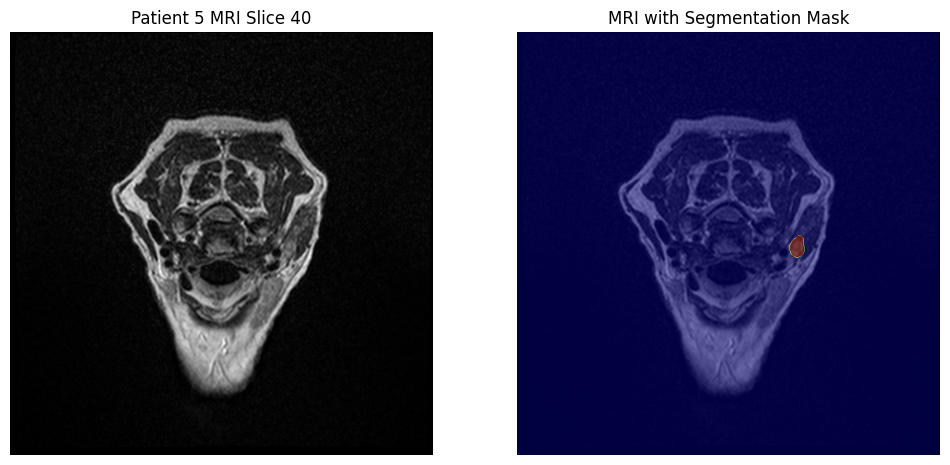

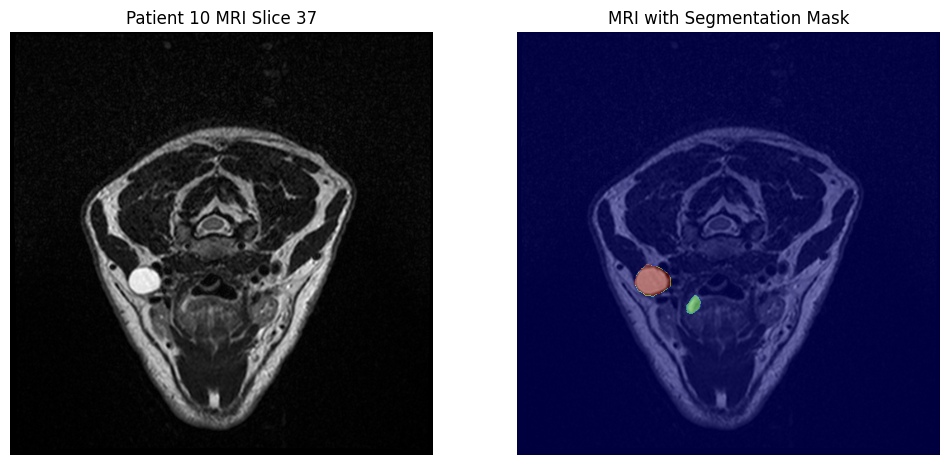

In [15]:
def plot_sample(patient_id, slice_index=None):
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # If no slice index is provided, use the middle slice
    if slice_index is None:
        slice_index = mri_data.shape[2] // 2
    
    mri_slice = mri_data[:, :, slice_index]
    mask_slice = mask_data[:, :, slice_index]
    
    # Plot MRI and Mask
    plt.figure(figsize=(12, 6))
    
    # MRI Image
    plt.subplot(1, 2, 1)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.title(f'Patient {patient_id} MRI Slice {slice_index}')
    plt.axis('off')
    
    # Mask Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.imshow(mask_slice.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title('MRI with Segmentation Mask')
    plt.axis('off')
    
    plt.show()

# Plot samples from a few patients
sample_patients = ['2', '5', '10']
for pid in sample_patients:
    plot_sample(pid)

# **Step 3: Data Preprocessing**

In [28]:
import torch
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    EnsureTyped
)
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

In [17]:
# Create data dictionaries
data_dicts = [
    {
        "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
        "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
    }
    for pid in patient_folders
]

**Split the dataset into training and validation**

In [18]:
# Split data into training and validation sets
train_files = data_dicts[:130]  # First 130 patients for training
val_files = data_dicts[130:]    # Remaining for validation

**Transform image**

In [33]:
# Define the desired spatial size (should be divisible by 16)
desired_shape = (512, 512, 64)
# Update the transforms to include resizing
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),           # Load images and labels
    EnsureChannelFirstd(keys=["image", "label"]),  # Ensure channel dimension
    ScaleIntensityd(keys=["image"]),               # Scale image intensity to [0, 1]
    Resized(keys=["image", "label"], spatial_size=desired_shape, mode=("trilinear", "nearest")),
    EnsureTyped(keys=["image", "label"]),          # Convert to PyTorch tensors
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"]),
    Resized(keys=["image", "label"], spatial_size=desired_shape, mode=("trilinear", "nearest")),
    EnsureTyped(keys=["image", "label"]),
])

**Create dataset and dataloaders**

In [34]:
# Create datasets
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

Loading dataset: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


# **Step 4: Build Model**

Define Model, Loss, Optimizer, and Metrics

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model (3D UNet)
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,  # Number of classes (background + 2 classes)
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Use DiceCELoss to handle class imbalance
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define Dice metric for evaluation
dice_metric = DiceMetric(include_background=False, reduction="mean") # TODO: Include background???

# **Step 5: Train and Validate Model**

In [36]:
# Training Loop
max_epochs = 10
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        # Get inputs and labels
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_function(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    print(f"Training loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        dice_metric.reset()
        for val_data in val_loader:
            val_inputs = val_data["image"].to(device)
            val_labels = val_data["label"].to(device)
            val_outputs = model(val_inputs)
            val_outputs = torch.softmax(val_outputs, dim=1)
            dice_metric(y_pred=val_outputs, y=val_labels)
        metric = dice_metric.aggregate().item()
        dice_metric.reset()
        print(f"Validation Dice Score: {metric:.4f}")

Epoch 1/10
Training loss: 0.9904
Validation Dice Score: 0.0021
Epoch 2/10
Training loss: 0.6874
Validation Dice Score: 0.0021
Epoch 3/10
Training loss: 0.6600
Validation Dice Score: 0.0021
Epoch 4/10
Training loss: 0.6399
Validation Dice Score: 0.0021
Epoch 5/10
Training loss: 0.6232
Validation Dice Score: 0.0021
Epoch 6/10
Training loss: 0.5990
Validation Dice Score: 0.0021
Epoch 7/10
Training loss: 0.6004
Validation Dice Score: 0.0021
Epoch 8/10
Training loss: 0.5827
Validation Dice Score: 0.0021
Epoch 9/10
Training loss: 0.5707
Validation Dice Score: 0.0021
Epoch 10/10
Training loss: 0.5676
Validation Dice Score: 0.0021


# **Step 6: Evaluate Model**

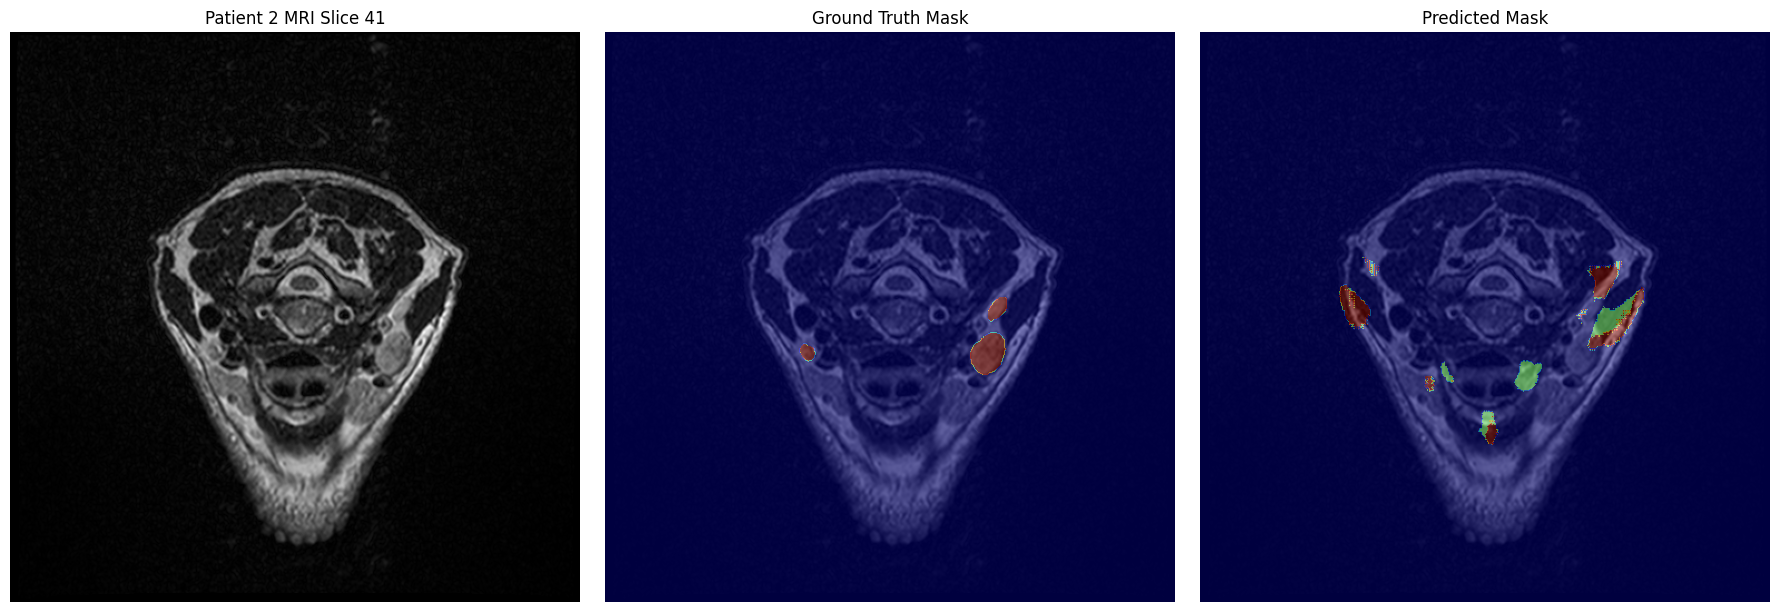

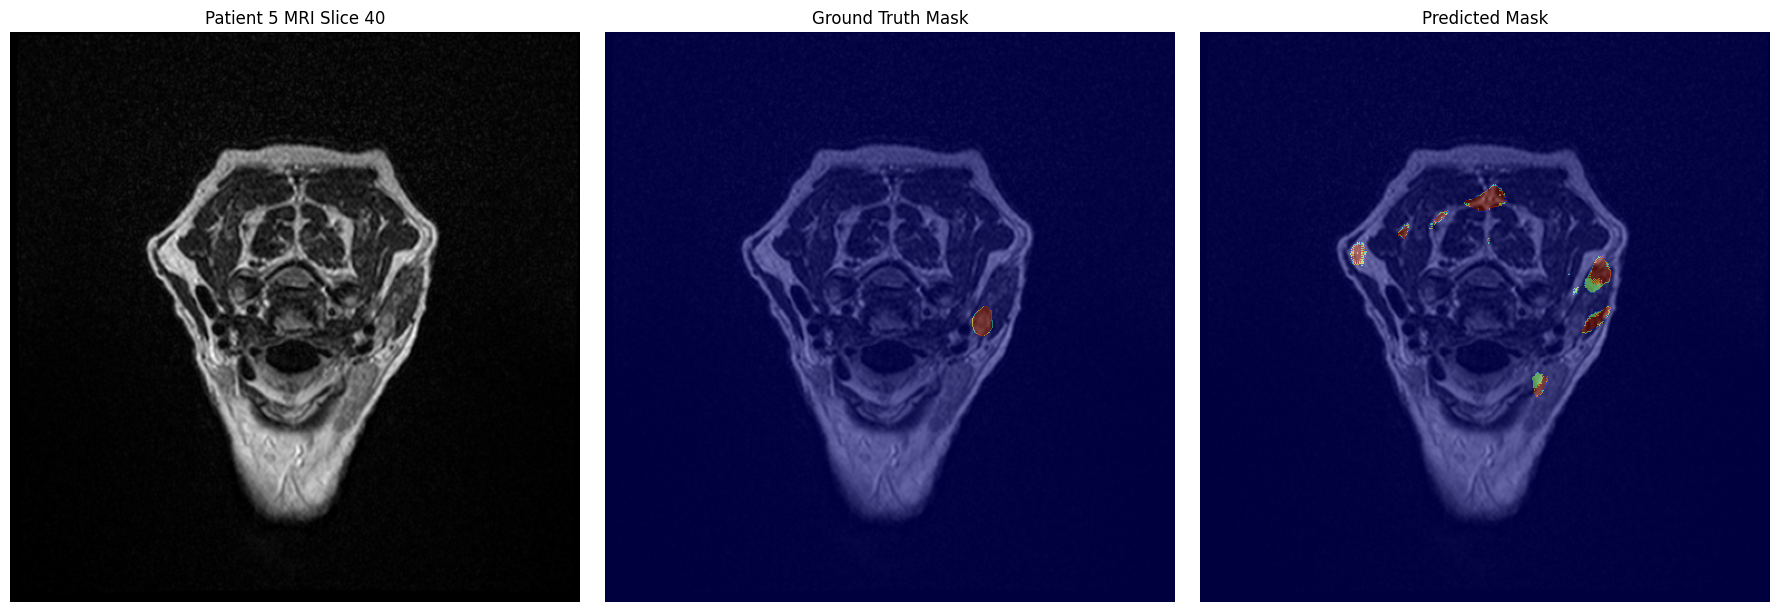

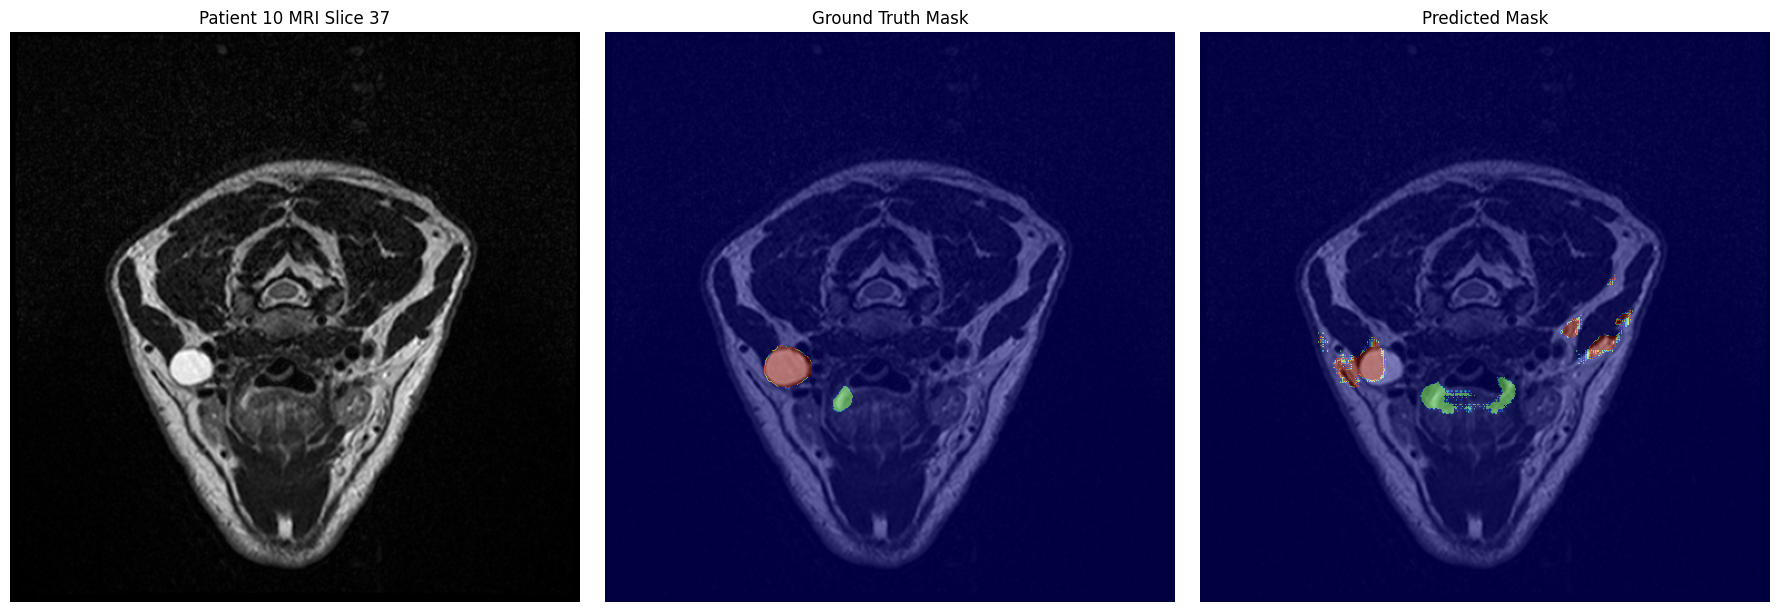

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os

def plot_prediction(model, patient_id, slice_index=None, device='cpu'):
    """
    Plots the MRI slice along with the ground truth and predicted segmentation masks.

    Args:
        model (torch.nn.Module): Trained segmentation model.
        patient_id (str): Identifier for the patient.
        slice_index (int, optional): Specific slice to visualize. If None, uses the middle slice.
        device (str, optional): Device to perform computations on ('cpu' or 'cuda').
    """
    model.eval()  # Set model to evaluation mode
    
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # If no slice index is provided, use the middle slice
    if slice_index is None:
        slice_index = mri_data.shape[2] // 2
    
    # Preprocess the MRI data similarly to training
    with torch.no_grad():
        # Prepare the input tensor
        input_dict = {
            "image": mri_path,
            "label": mask_path
        }
        processed = val_transforms(input_dict)
        input_tensor = processed["image"].unsqueeze(0).to(device)  # Add batch dimension
        
        # Run the model
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()
    
    # Extract the relevant slice
    mri_slice = mri_data[:, :, slice_index]
    mask_slice = mask_data[:, :, slice_index]
    predicted_slice = predicted[:, :, slice_index]
    
    # Plot MRI, Ground Truth, and Prediction
    plt.figure(figsize=(18, 6))
    
    # MRI Image
    plt.subplot(1, 3, 1)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.title(f'Patient {patient_id} MRI Slice {slice_index}')
    plt.axis('off')
    
    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.imshow(mask_slice.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.imshow(predicted_slice.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Ensure the model is on the correct device
model.to(device)

# Define a list of patient IDs you want to visualize
# Replace these with actual patient IDs from your validation set
sample_patients = ['2', '5', '10']  # Example patient IDs

# Plot predictions for each selected patient
for pid in sample_patients:
    plot_prediction(model, patient_id=pid, device=device)
